# Import

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [2]:
def check_pk(df_pl: pl.DataFrame, cols: list) -> None:
    """xx"""

    # 重複のない組み合わせの数
    unique_combinations = df_pl.unique(subset=cols).height

    # データ全体の行数
    total_rows = len(df_pl)

   # 比較して一意性を確認
    if unique_combinations == total_rows:
        print(f"{', '.join(cols)} の組み合わせは一意であり、PKとして使用できます。")
    else:
        print(f"{', '.join(cols)} の組み合わせには重複があります。重複している行数は {total_rows - unique_combinations} 行です。")

In [3]:
def check_n_unique(df_pl: pl.DataFrame, col: str) -> None:
    """xx"""

    _n_unique = df_pl[col].n_unique()
    print(f"{col}のユニーク件数： {_n_unique}")

In [4]:
def plot_record_cnts_by_d(city_df: pl.DataFrame) -> None:
    """日単位(d)でレコード数の推移を可視化するグラフを描画"""

    # プロットのためにデータ加工
    agg_df = city_df.group_by("d").len().sort("d")


    # グラフの描画
    plt.figure(figsize = (10, 6))
    plt.plot(agg_df["d"], agg_df["len"], marker='o', label='Data Count')

    plt.xlabel("d")
    plt.ylabel("counts")
    plt.xlim()
    plt.ylim()
    plt.grid(True)
    plt.legend() # 凡例を追加
    plt.show()


In [5]:
def plot_n_unique_heatmap(city_df: pl.DataFrame) -> None:
    """x, y 座標ごとのデータ数をヒートマップで可視化"""

    # 999で位置がマスクされた実績は排除
    city_df = city_df.filter((pl.col("x")!=999)&(pl.col("y")!=999))

    # x, y 座標ごとのデータ数をカウント
    agg_df = city_df.group_by(['x', 'y']).agg(pl.len()).sort(['x', 'y'])

    # 外れ値があるので対数変換してから可視化
    agg_df_log = agg_df.with_columns((pl.col("len") + 1).log())

    # データをピボットテーブルに変換
    pivot_df = agg_df_log.pivot(values="len", index="y", columns="x")

    # x, yで欠損していた場合には0埋めを行う
    pivot_df = pivot_df.fill_null(0)

    # y列をindexで扱うためpolarsからpandasへ返還
    pd_pivot_df = pivot_df.to_pandas()
    pd_pivot_df = pd_pivot_df.set_index('y').sort_index(ascending=True)

    # ヒートマップの描画
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd_pivot_df, annot=False, fmt="d", cmap="YlGnBu", cbar=True)

    plt.title("Heatmap of Data Counts on log scale by (x, y) Coordinates")
    plt.xlabel("x Coordinate")
    plt.ylabel("y Coordinate")
    plt.show()

# Dataset

## 2024年データセット

## データセットと課題の概要

### 1. データセットの概要
- **都市とグリッド**: 
  - データは、4つの都市（A、B、C、D）の500メートル x 500メートルのグリッドに分割されています。それぞれの都市は、200 x 200のグリッド（合計40,000セル）でカバーされています。
- **期間と時間間隔**:
  - 人々の移動データは、75日間にわたって収集されています。時間は30分ごとに区切られており、各グリッドセルにおける人々の位置が記録されています。
- **個人の移動データ**:
  - 都市Aでは10万人、都市Bでは2万5000人、都市Cでは2万人、都市Dでは6000人の個人の移動データが収集されています。これらのデータは、それぞれの日ごとに30分間隔で記録されています。

### 2. 課題の概要
- **予測対象**:
  - 課題は、都市B、C、Dの各都市において、特定の3000人の移動を、61日目から75日目まで予測することです。
- **利用可能なデータ**:
  - 都市Aの全75日間の移動データ（10万人分）が提供されています。また、都市B、C、Dのデータも、各都市についてそれぞれの人口のデータが提供されています。ただし、予測対象の都市において61日目から75日目の特定の個人の位置はマスクされており、これらの位置が '999' という特殊なセル番号で示されています。
- **データの選択と活用**:
  - 予測に使用するデータの選択は自由であり、例えば都市Bの予測には都市Bの1日目から60日目のデータのみを使用することもできます。また、他の都市のデータ（例：都市A）を使用して予測精度を向上させることも可能ですが、それが必ずしも有効とは限りません。

### 3. 補足情報（POIデータ）
- **ポイントオブインタレスト（POI）データ**:
  - 各グリッドセルに関連付けられたポイントオブインタレスト（POI）の情報が提供されています。POIは、レストランや公園など、約85種類のカテゴリーに分類されています。この情報は、移動パターンの背景を理解し、予測モデルの改善に役立てることができます。
- **POIデータの形式**:
  - 各都市のグリッドセルに対して、約85次元のベクトルとしてPOIデータが提供されています。これらのデータは、例えば都市Aについては `POIdata_cityA` として提供されています。

### 4. データ利用の戦略
- **都市Aのデータ利用**:
  - 都市Aの完全なデータセットを利用して、移動パターンや行動モデルを学習することが可能です。これを基に他の都市（B、C、D）の移動を予測するアプローチが考えられます。
- **他都市のデータの組み合わせ**:
  - 都市B、C、Dのデータをどのように組み合わせて予測するかが戦略の鍵となります。都市ごとの特徴やPOIの分布を考慮して、どのデータを使うかを決定します。
- **POIデータの活用**:
  - POIデータを使って、特定のグリッドセルに人が集まりやすい時間帯や場所をモデルに組み込むことができます。これにより、より精度の高い予測が期待できます。

### 5. 目的と挑戦
- **目的**:
  - このチャレンジの目的は、都市ごとの人々の移動パターンを予測することであり、特に指定された期間における移動予測の精度を競うことです。
- **挑戦**:
  - 異なる都市間での移動パターンの相違や、都市ごとの特性を考慮したモデリングが求められます。また、予測する日付の移動データがマスクされているため、不確実性を伴うデータをどのように処理するかが課題となります。


### city{A, B, C, D}_groundtruthdata.csv.gz

In [6]:
# CSV.GZファイルを読み込む
df_a = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/cityA_groundtruthdata.csv.gz")

# データフレームの内容を表示
display(df_a.head(1))
print(len(df_a))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,1,79,86


111535175


In [7]:
check_pk(df_a, ["uid", "d", "t"])

uid, d, t の組み合わせは一意であり、PKとして使用できます。


In [8]:
for col in ["uid", "d", "t"]:
    check_n_unique(df_a, col)

# 100,000 * 75 * 48 = 360,000,000
# 受領データは111,535,175なので
# 360,000,000 - 111,535,175 = 248,464,825件が欠損している


uidのユニーク件数： 100000
dのユニーク件数： 75
tのユニーク件数： 48


In [9]:
print(df_a.min())
print(df_a.max())

shape: (1, 5)
┌─────┬─────┬─────┬─────┬─────┐
│ uid ┆ d   ┆ t   ┆ x   ┆ y   │
│ --- ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╪═════╡
│ 0   ┆ 0   ┆ 0   ┆ 1   ┆ 1   │
└─────┴─────┴─────┴─────┴─────┘
shape: (1, 5)
┌───────┬─────┬─────┬─────┬─────┐
│ uid   ┆ d   ┆ t   ┆ x   ┆ y   │
│ ---   ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64   ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═══════╪═════╪═════╪═════╪═════╡
│ 99999 ┆ 74  ┆ 47  ┆ 200 ┆ 200 │
└───────┴─────┴─────┴─────┴─────┘


In [10]:
_tmp = df_a.filter(pl.col("uid")==0)

for col in ["uid", "d", "t"]:
    check_n_unique(_tmp, col)

uidのユニーク件数： 1
dのユニーク件数： 64
tのユニーク件数： 46


In [11]:
display(_tmp)

# 結構欠損してそう。。

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,1,79,86
0,0,2,79,86
0,0,8,77,86
0,0,9,77,86
0,0,19,81,89
0,0,20,82,88
0,0,21,81,89
0,0,22,81,89
0,0,24,76,86


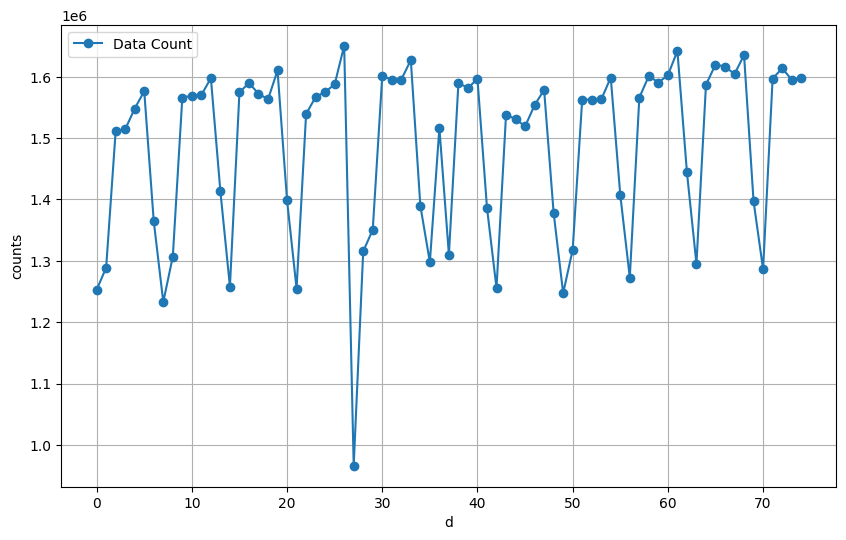

In [12]:
plot_record_cnts_by_d(df_a)

# 前回とほぼ同じ傾向 -> となるとコロナ期の人流データで認識
# A~D比べたが同じグラフパターンなので同期間としてOK

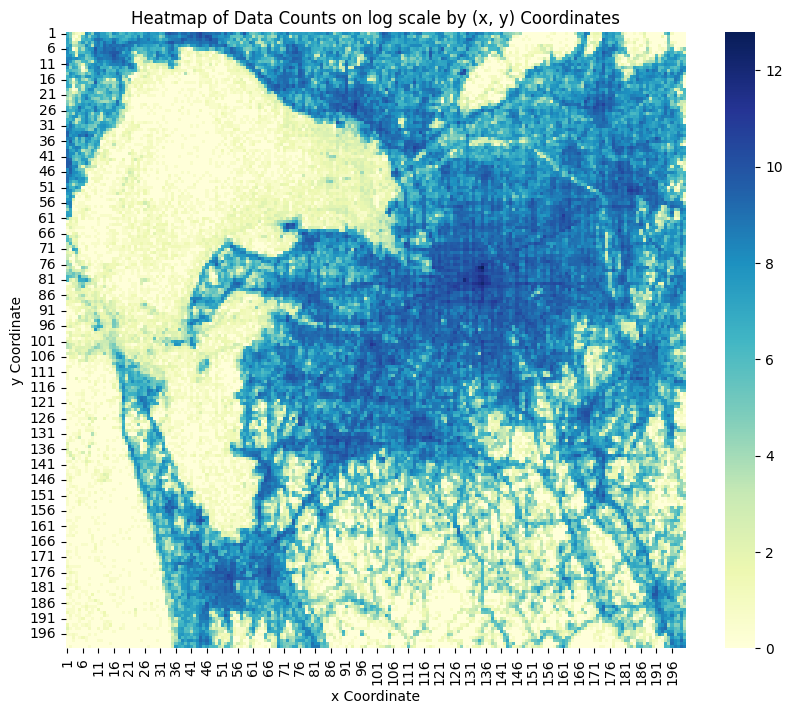

In [13]:
plot_n_unique_heatmap(df_a)

In [14]:
# CSV.GZファイルを読み込む
df_b = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz")

# データフレームの内容を表示
display(df_b.head(1))
print(len(df_b))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,20,80,99


24375898


In [15]:
check_pk(df_b, ["uid", "d", "t"])

uid, d, t の組み合わせは一意であり、PKとして使用できます。


In [16]:
for col in ["uid", "d", "t"]:
    check_n_unique(df_b, col)

uidのユニーク件数： 25000
dのユニーク件数： 75
tのユニーク件数： 48


In [17]:
print(df_b.min())
print(df_b.max())

shape: (1, 5)
┌─────┬─────┬─────┬─────┬─────┐
│ uid ┆ d   ┆ t   ┆ x   ┆ y   │
│ --- ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╪═════╡
│ 0   ┆ 0   ┆ 0   ┆ 1   ┆ 1   │
└─────┴─────┴─────┴─────┴─────┘
shape: (1, 5)
┌───────┬─────┬─────┬─────┬─────┐
│ uid   ┆ d   ┆ t   ┆ x   ┆ y   │
│ ---   ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64   ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═══════╪═════╪═════╪═════╪═════╡
│ 24999 ┆ 74  ┆ 47  ┆ 999 ┆ 999 │
└───────┴─────┴─────┴─────┴─────┘


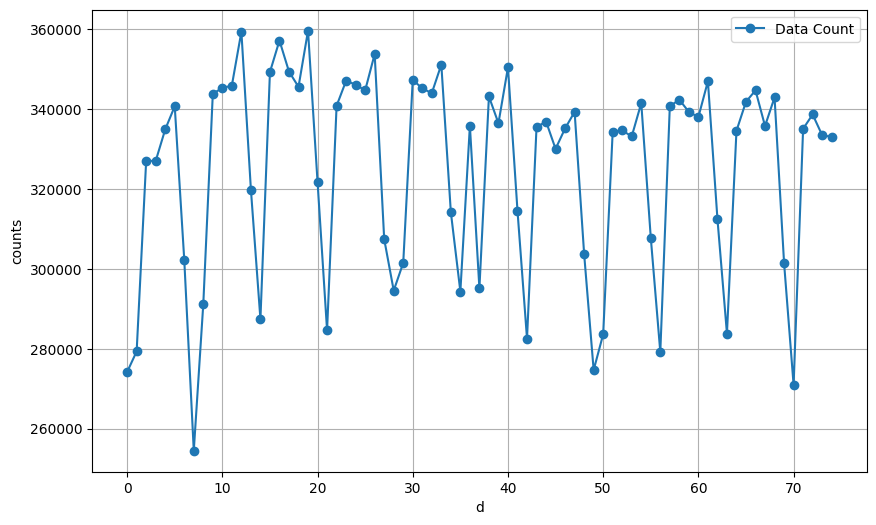

In [18]:
plot_record_cnts_by_d(df_b)

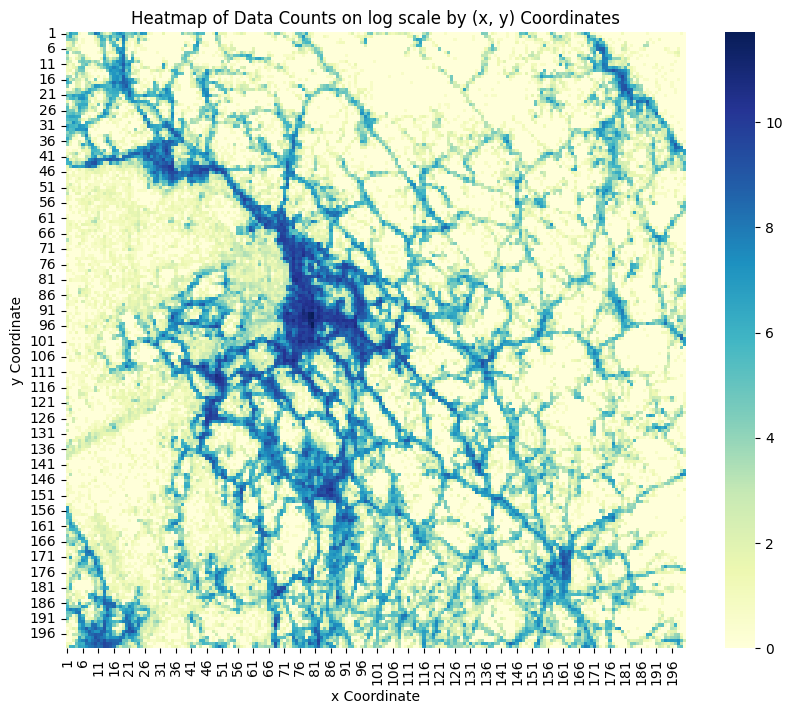

In [19]:
plot_n_unique_heatmap(df_b)

In [20]:
# CSV.GZファイルを読み込む
df_c = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/cityC_challengedata.csv.gz")

# データフレームの内容を表示
display(df_c.head(1))
print(len(df_c))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,5,15,28,157


18456528


In [21]:
check_pk(df_c, ["uid", "d", "t"])

uid, d, t の組み合わせは一意であり、PKとして使用できます。


In [22]:
for col in ["uid", "d", "t"]:
    check_n_unique(df_c, col)

uidのユニーク件数： 20000
dのユニーク件数： 75
tのユニーク件数： 48


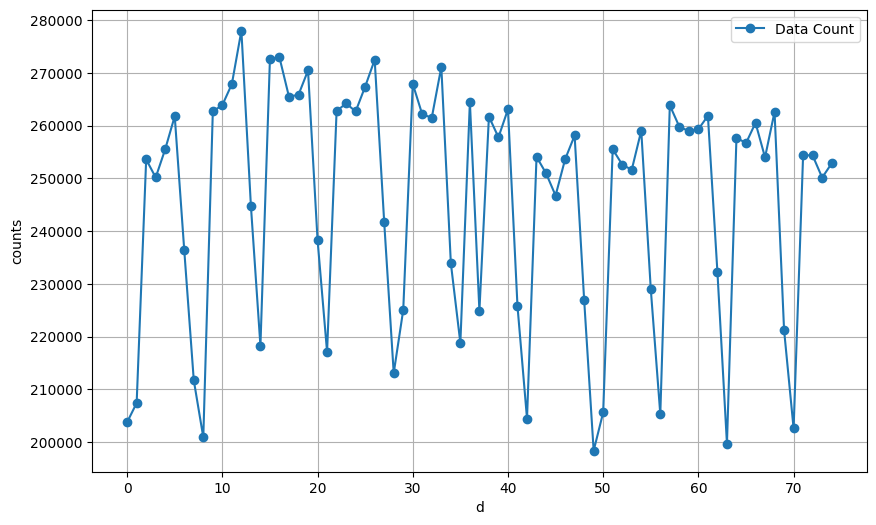

In [23]:
plot_record_cnts_by_d(df_c)

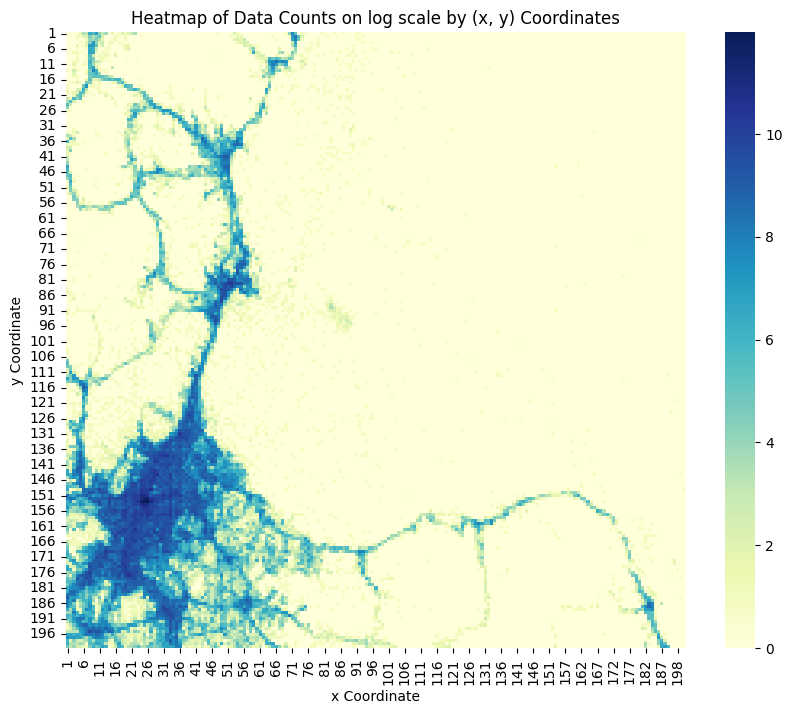

In [24]:
plot_n_unique_heatmap(df_c)

In [25]:
# CSV.GZファイルを読み込む
df_d = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/cityD_challengedata.csv.gz")

# データフレームの内容を表示
display(df_d.head(1))
print(len(df_d))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,13,133,103


8418135


In [26]:
check_pk(df_d, ["uid", "d", "t"])

uid, d, t の組み合わせは一意であり、PKとして使用できます。


In [27]:
for col in ["uid", "d", "t"]:
    check_n_unique(df_d, col)

uidのユニーク件数： 6000
dのユニーク件数： 75
tのユニーク件数： 48


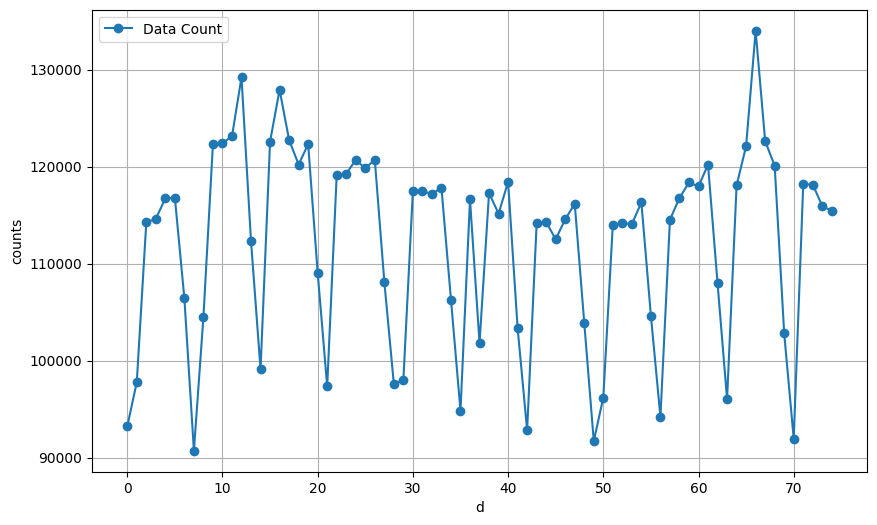

In [28]:
plot_record_cnts_by_d(df_d)

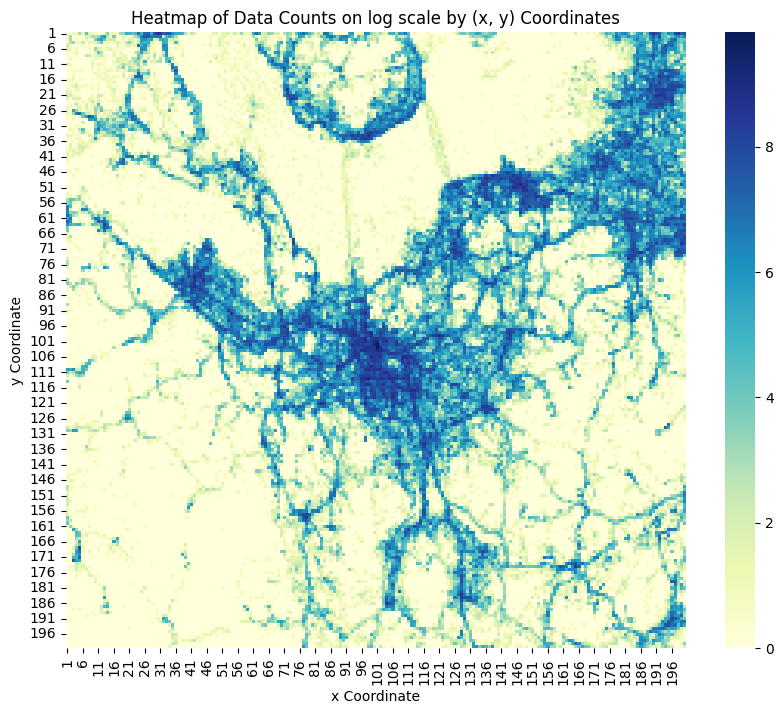

In [29]:
plot_n_unique_heatmap(df_d)

### POIdata_city{A, B, C, D}.csv

In [30]:
# CSV.GZファイルを読み込む
df_a_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityA.csv")

# データフレームの内容を表示
display(df_a_poi.head(1))
print(len(df_a_poi))

x,y,category,POI_count
i64,i64,i64,i64
1,1,74,4


221248


In [31]:
check_pk(df_a_poi, ["x", "y", "category"])

x, y, category の組み合わせは一意であり、PKとして使用できます。


In [32]:
category_min = df_a_poi["category"].min()
category_max = df_a_poi["category"].max()

print(f"POIのcategory値の最小値は {category_min}")
print(f"POIのcategory値の最大値は {category_max}")

POIのcategory値の最小値は 1
POIのcategory値の最大値は 85


In [33]:
# CSV.GZファイルを読み込む
df_b_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityB.csv")

# データフレームの内容を表示
display(df_b_poi.head(1))
print(len(df_b_poi))

x,y,category,POI_count
i64,i64,i64,i64
1,1,79,2


56181


In [34]:
check_pk(df_b_poi, ["x", "y", "category"])

x, y, category の組み合わせは一意であり、PKとして使用できます。


In [35]:
# CSV.GZファイルを読み込む
df_c_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityC.csv")

# データフレームの内容を表示
display(df_c_poi.head(1))
print(len(df_c_poi))

x,y,category,POI_count
i64,i64,i64,i64
1,35,48,1


39064


In [36]:
check_pk(df_c_poi, ["x", "y", "category"])

x, y, category の組み合わせは一意であり、PKとして使用できます。


In [37]:
# CSV.GZファイルを読み込む
df_d_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityD.csv")

# データフレームの内容を表示
display(df_d_poi.head(1))
print(len(df_d_poi))

x,y,category,POI_count
i64,i64,i64,i64
1,11,46,1


72794


In [38]:
check_pk(df_d_poi, ["x", "y", "category"])

x, y, category の組み合わせは一意であり、PKとして使用できます。


### POI_datacategories.csv

In [39]:
# CSV.GZファイルを読み込む
df_poi_category = (
    pl.read_csv(
        "/kaggle/s3storage/01_public/humob-challenge-2024/input/POI_datacategories.csv",
        has_header=False, 
        new_columns=["poi_category"])
)

df_poi_category = df_poi_category.with_row_count("category_no", 1)

# データフレームの内容を表示
display(df_poi_category.head(1))
print(len(df_poi_category))

/tmp/ipykernel_83320/3365231361.py:9: DeprecationWarning: `with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df_poi_category = df_poi_category.with_row_count("category_no", 1)


category_no,poi_category
u32,str
1,"""Food"""


85


In [40]:
for v in df_poi_category["poi_category"]:
    print(v)

Food
Shopping
Entertainment
Japanese restaurant
Western restaurant
Eat all you can restaurant
Chinese restaurant
Indian restaurant
Ramen restaurant
Curry restaurant
BBQ restaurant
Hot pot restaurant
Bar
Diner
Creative cuisine
Organic cuisine
Pizza
Café
Tea Salon
Bakery
Sweets 
Wine Bar
Pub
Disco
Beer Garden
Fast Food
Karaoke
Cruising
Theme Park Restaurant
Amusement Restaurant
Other Restaurants
Glasses
Drug Store
Electronics Store
DIY Store
Convenience Store
Recycle Shop
Interior Shop
Sports Store
Clothes Store
Grocery Store
Online Grocery Store
Sports Recreation
Game Arcade
Swimming Pool
Hotel
Park
Transit Station
Parking Area
Casino
Hospital
Pharmacy
Chiropractic
Elderly Care Home
Fishing
School
Cram School
Kindergarten
Real Estate
Home Appliances
Post Office
Laundry 
Driving School
Wedding Ceremony
Cemetary
Bank
Vet
Hot Spring
Hair Salon
Lawyer Office
Recruitment Office
City Hall
Community Center
Church
Retail Store
Accountant Office
IT Office
Publisher Office
Building Material
Garde

## 2023年データセット

In [41]:
# CSV.GZファイルを読み込む
pre_df_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/00_lastyear-dataset-humob2023/POI_datacategories.csv")

# データフレームの内容を表示
display(pre_df_poi.head(1))
print(len(pre_df_poi))

Food
str
"""Shopping"""


84


In [42]:
# CSV.GZファイルを読み込む
pre_df_1 = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/00_lastyear-dataset-humob2023/yjmob100k-dataset1.csv.gz")

# データフレームの内容を表示
display(pre_df_1.head(1))
print(len(pre_df_1))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,1,79,86


111535175


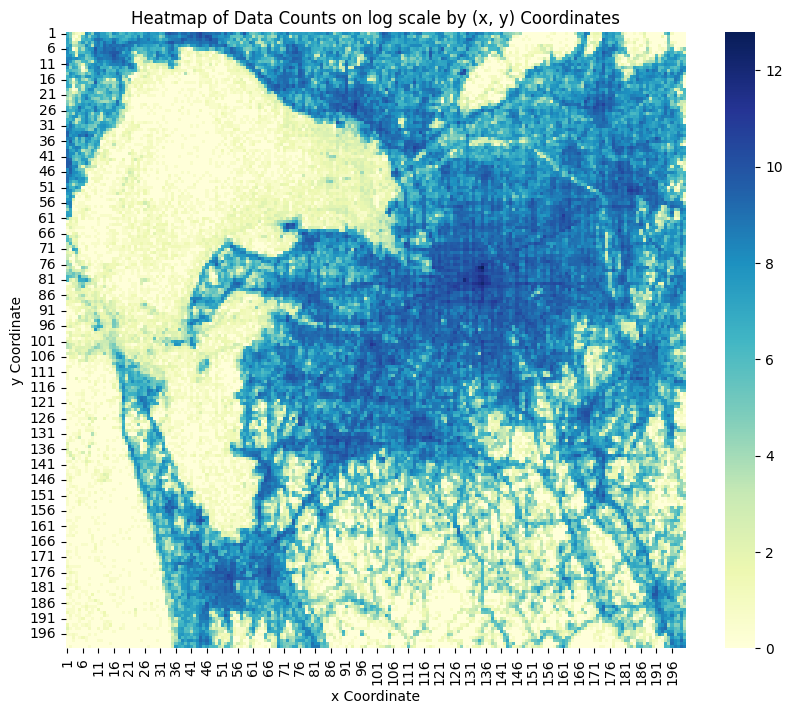

In [43]:
plot_n_unique_heatmap(pre_df_1)

In [44]:
# CSV.GZファイルを読み込む
pre_df_2 = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/00_lastyear-dataset-humob2023/yjmob100k-dataset2.csv.gz")

# データフレームの内容を表示
display(pre_df_2.head(1))
print(len(pre_df_2))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,0,163,60


29389749


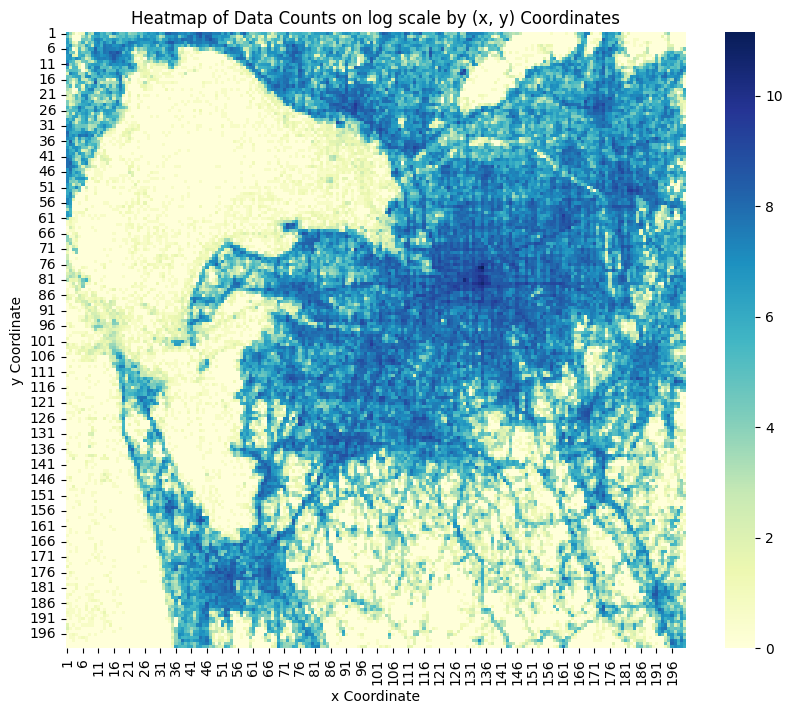

In [45]:
plot_n_unique_heatmap(pre_df_2)